In [2]:
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import mlflow
import os


The dataset is here: https://www.kaggle.com/datasets/nehaprabhavalkar/av-healthcare-analytics-ii


The aim of the dataset is to predict hospital length of stay - which is represented by the ``stay`` column. Interesting it is discretized into 11 different categories. 
The question is to treat as classification or as an ordinal regression task.....

In [53]:
df_dictionary = pd.read_csv('../data/train_data_dictionary.csv')

In [54]:
df_dictionary

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


In [2]:
df = pd.read_csv('../data/train_data.csv')
df = df.drop(['case_id'], axis=1)

In [3]:
df.dtypes

Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [56]:
df.describe()

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


In [57]:
# target colum
df.groupby('Stay')['Stay'].count()

Stay
0-10                  23604
11-20                 78139
21-30                 87491
31-40                 55159
41-50                 11743
51-60                 35018
61-70                  2744
71-80                 10254
81-90                  4838
91-100                 2765
More than 100 Days     6683
Name: Stay, dtype: int64

## Pre Processing

In [3]:
# Turning target column into a numeric option
df['Stay_numeric'] = df['Stay'].map(
{'0-10': 1,
'11-20': 2,
'21-30': 3,
'31-40': 4,
'41-50': 5,
'51-60': 6,
'61-70': 7,
'71-80': 8,
'81-90': 9,
'91-100': 10,
'More than 100 Days':11})

# Dichotomise into admitted for Longer then 30 days or not
df['long_stay'] = df['Stay_numeric']>3
df['long_stay'] = df['long_stay'].replace({True:1, False:0})


# Encode categorical variables and treat like ordinal
le = LabelEncoder()
columns_to_encode = [
    "Hospital_type_code",
    "Hospital_region_code",
    "Department",
    "Ward_Type",
    "Ward_Facility_Code",
    "Type of Admission",
    "Severity of Illness",
    "City_Code_Patient"
]

for column in columns_to_encode:
    # if column == "City_Code_Patient":
    #     df[column] = df[column].astype('int')
    # else:
        df[column] = le.fit_transform(df[column].values)

# If hosp and patient are in same city
df['hosp_patient_same'] = [1 if i == j else 0 for i, j in zip(df["City_Code_Hospital"].values, df['City_Code_Patient'].values)]

# Gender. 1 -> Female, 0 -> Male
df["Gender"] = [1 if i=="gynecology" else 0 for i in df["Department"].values]


# Number of hospitals in a city
df["Num_hospitals"] = df.groupby(["City_Code_Hospital"])["Hospital_code"].nunique()
df["Num_hospitals"] = df["Num_hospitals"].fillna(0)

# number of unique hospitals visited
df['unique_hospital_visited']=df.groupby('patientid')['Hospital_code'].transform('nunique')

class_map = {"0-10": 0, "11-20": 1, "21-30": 2, "31-40": 3, "41-50": 4, "51-60": 5, "61-70": 6, "71-80": 7, "81-90": 8, "91-100": 9, "More than 100 Days": 10}
#class_map_rev = {0: "0-10", 1: "11-20", 2: "21-30", 3: "31-40", 4: "41-50", 5: "51-60", 6: "61-70", 7: "71-80", 8: "81-90", 9: "91-100", 10: "More than 100 Days"}

df["Age"] = [(class_map[i]*10)+1 for i in df["Age"].values]


# drop any left over na's
df = df.dropna()


# Remove unneeded columns
df = df.drop(['Stay', 'Stay_numeric'], axis=1)

In [4]:
# Test train split
y = df['long_stay']
X = df.drop(['long_stay'], axis=1)

# split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## EDA

<Axes: >

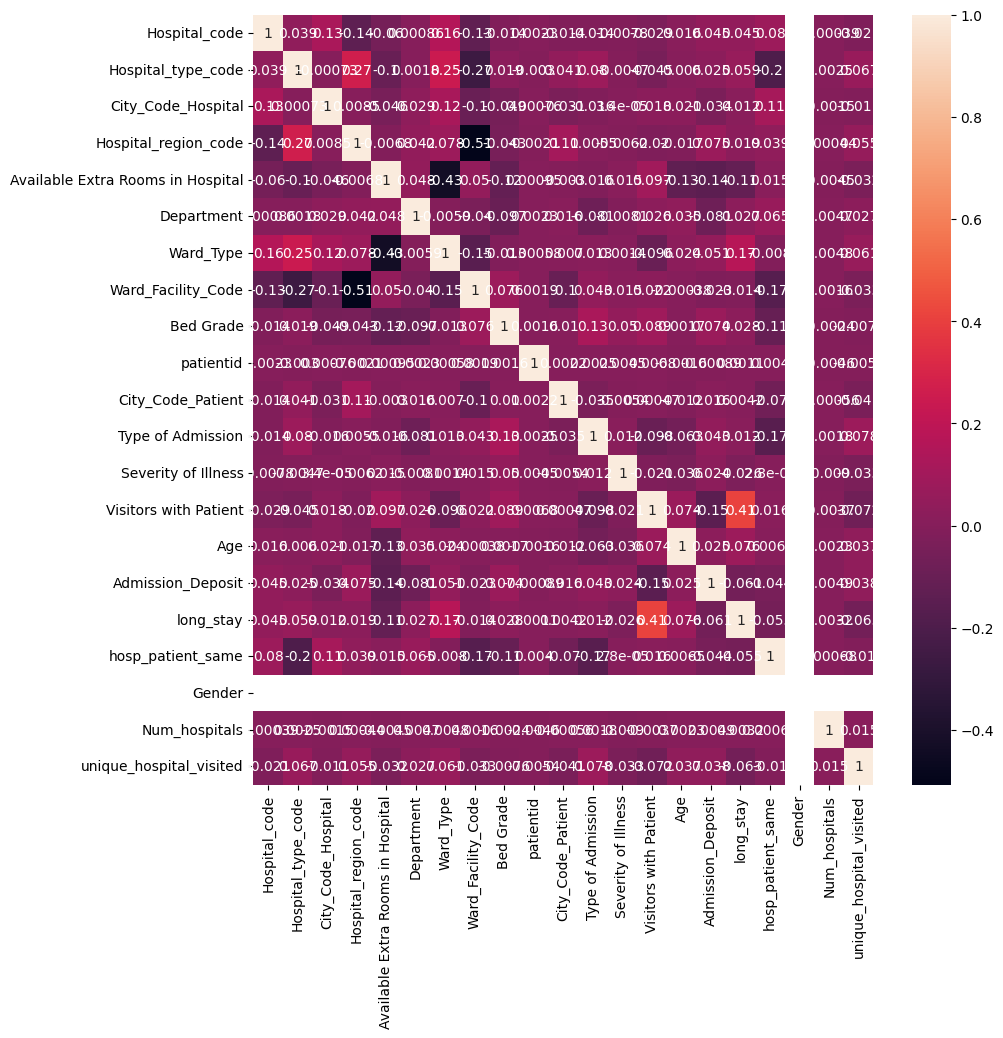

In [60]:
# Calculate correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix,annot=True)


In [61]:
def train_test_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model = model

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the target variable for the test set
    y_pred = model.predict(X_test)

    # Create and print the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    print("Normalized Confusion Matrix:")
    print(cm)

    # Calculate and print the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate the predicted probabilities and AUC score
    y_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    print("AUC Score:", auc_score)
    
    return model

## ML Modelling

In [62]:
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the test set
# Predict the target variable for the test set
y_pred = model.predict(X_test)

# Create and print the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
print("Normalized Confusion Matrix:")
print(cm)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the predicted probabilities and AUC score
y_prob = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)

Normalized Confusion Matrix:
[[0.85740325 0.14259675]
 [0.43827974 0.56172026]]
Accuracy: 0.7375323961360245
AUC Score: 0.7558155507943375


/home/antihaddock/anaconda3/envs/mlopscamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
model = LogisticRegression()
train_test_model(model)

Normalized Confusion Matrix:
[[0.85740325 0.14259675]
 [0.43827974 0.56172026]]
Accuracy: 0.7375323961360245
AUC Score: 0.7558155507943375


/home/antihaddock/anaconda3/envs/mlopscamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [64]:
model = RandomForestClassifier()
train_test_model(model)

Normalized Confusion Matrix:
[[0.92698455 0.07301545]
 [0.39259977 0.60740023]]
Accuracy: 0.7974240163355062
AUC Score: 0.8335851610820895


RandomForestClassifier()

In [65]:
#model = XGBClassifier()
#train_test_model(model)


## Wrap our model training into a mlflow workflow

In [66]:
def train_test_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
       
       #tracking_uri = "../mlflow_models/"
       tracking_uri = 'http://0.0.0.0:8000' 
       mlflow.set_tracking_uri(tracking_uri)
       mlflow.set_experiment('HospitalPrediction')
       with mlflow.start_run():
              mlflow.log_param("model_name", type(model).__name__)
              model = model

              # Fit the model to the training data
              model.fit(X_train, y_train)

              # Predict the target variable for the test set
              y_pred = model.predict(X_test)

              # Create and print the confusion matrix
              cm = confusion_matrix(y_test, y_pred, normalize='true')
              print("Normalized Confusion Matrix:")
              print(cm)

              # Calculate and print the accuracy score
              accuracy = accuracy_score(y_test, y_pred)
              mlflow.log_metric("accuracy", accuracy)
              print("Accuracy:", accuracy)

              # Calculate the predicted probabilities and AUC score
              y_prob = model.predict_proba(X_test)[:, 1]
              auc_score = roc_auc_score(y_test, y_prob)
              mlflow.log_metric("auc_score", auc_score)
              print("AUC Score:", auc_score)

              # Save the model as an artifact
              mlflow.sklearn.log_model(model, "model")
       return model

models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]

for model in models:
       train_test_model(model)

2023/06/18 19:45:15 INFO mlflow.tracking.fluent: Experiment with name 'HospitalPrediction' does not exist. Creating a new experiment.
/home/antihaddock/anaconda3/envs/mlopscamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Normalized Confusion Matrix:
[[0.85740325 0.14259675]
 [0.43827974 0.56172026]]
Accuracy: 0.7375323961360245
AUC Score: 0.7558155507943375
Normalized Confusion Matrix:
[[0.9264298 0.0735702]
 [0.3938396 0.6061604]]
Accuracy: 0.7965915338097856
AUC Score: 0.8336148743720239


### Find, return and load the serialized best model for use

In [ ]:
def best_model(experiment_name):
    """
    Returns:
    model: Loads the model with the best AUC value saved into MLflow for use
    """
    tracking_uri = 'http://0.0.0.0:8000'
    mlflow.set_tracking_uri(tracking_uri)
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    runs = mlflow.search_runs(experiment_ids=[experiment_id])
    # Filter the runs based on the specified run_name
    best_run = runs.loc[runs['metrics.auc_score'].idxmax()]
    # Get the artifact URI for the best run
    artifact_uri = best_run['artifact_uri']

    # Load the model using the artifact URI
    model = mlflow.sklearn.load_model(artifact_uri + "/model")

    return model


In [ ]:
runs = mlflow.search_runs()

In [ ]:
model = best_model('HospitalPrediction')
model.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

/tmp/ipykernel_9381/1626239887.py:5: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [12]:
from evidently.report import Report
from evidently import ColumnMapping
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

def calculate_evidently_metrics(df, prediction):
    """_summary_

    Args:
        df (_type_): _description_
        prediction (_type_): _description_
    """
       
    reference_data = pd.read_csv('../data/train_data.csv')
    
    # Turning target column into a numeric option
    reference_data['Stay_numeric'] = reference_data['Stay'].map(
    {'0-10': 1,
    '11-20': 2,
    '21-30': 3,
    '31-40': 4,
    '41-50': 5,
    '51-60': 6,
    '61-70': 7,
    '71-80': 8,
    '81-90': 9,
    '91-100': 10,
    'More than 100 Days':11})

    # Dichotomise into admitted for Longer then 30 days or not
    reference_data['long_stay'] = reference_data['Stay_numeric']>3
    #reference_data['long_stay'] = reference_data['long_stay'].replace({True:1, False:0})
    target_column = reference_data['long_stay'].replace({True:1, False:0})
    
    reference_data = reference_data.drop(['Stay_numeric', 'Stay'],axis=1)
    reference_data = preprocess(reference_data)
    
    
    # num_features = ['Hospital_code',
    #                 'City_Code_Hospital',
    #                 'Available Extra Rooms in Hospital', 
    #                 'total_amount', 
    #                 'Bed Grade',
    #                 'patientid',  
    #                 'Admission_Deposit',  
    #                 'City_Code_Patient',
    #                 'Visitors with Patient',
    #                 'long_stay']
    # cat_features = ['Hospital_type_code',
    #                 'Hospital_region_code',
    #                 'Department', 
    #                 'Ward_Type',
    #                 'Ward_Facility_Code',
    #                 'Type of Admission',
    #                 'Severity of Illness',
    #                 'Age']
    
    num_features =['Hospital_code' ,
            'Hospital_type_code' ,
            'City_Code_Hospital' ,
            'Hospital_region_code' ,
            'Available_Extra_Rooms_in_Hospital' ,
            'Department' ,
            'Ward_Type' ,
            'Ward_Facility_Code' ,
            'Bed_Grade' ,
            'patientid' ,
            'City_Code_Patient' ,
            'Type_of_Admission' ,
            'Severity_of_Illness' ,
            'Visitors_with_Patient' ,
            'Age' ,
            'Admission_Deposit' ,
            'hosp_patient_same' ,
            'Gender' ,
            'Num_hospitals' ,
            'unique_hospital_visited' ,
            'prediction'
            ]
  
    column_mapping = ColumnMapping(
                    prediction=target_column,
                    numerical_features=num_features,
                    #categorical_features=cat_features,
                    target=None
                    )

    report = Report(metrics = [
                    ColumnDriftMetric(column_name='prediction'),
                    DatasetDriftMetric(),
                    DatasetMissingValuesMetric()
                    ])
    report.run(reference_data = reference_data, current_data = df,
	        	column_mapping=column_mapping)
    
    result = report.as_dict()
    prediction_drift = result['metrics'][0]['result']['drift_score']
    num_drifted_columns = result['metrics'][1]['result']['number_of_drifted_columns']
    share_missing_values = result['metrics'][2]['result']['current']['share_of_missing_values']
   
    # create a df to insert into the db off the report
    report_metrics = pd.DataFrame({'prediction_drift': prediction_drift,
                                   'num_drifted_columns': num_drifted_columns,
                                   'share_missing_values': share_missing_values})
    report_metrics['generated_at'] = datetime.now()
    
    engine = create_engine(credentials)
    table_name = 'evidently_report'
       
    #report_metrics.to_sql(table_name, engine, if_exists='append', index=False)

In [ ]:
# Making Evidently work

In [16]:
df_train = pd.read_csv('../data/train_data.csv')
df_train = df_train.drop(['case_id'], axis=1)

# Turning target column into a numeric option
df_train['Stay_numeric'] = df_train['Stay'].map(
{'0-10': 1,
'11-20': 2,
'21-30': 3,
'31-40': 4,
'41-50': 5,
'51-60': 6,
'61-70': 7,
'71-80': 8,
'81-90': 9,
'91-100': 10,
'More than 100 Days':11})

# Dichotomise into admitted for Longer then 30 days or not
df_train['long_stay'] = df_train['Stay_numeric']>3
df_train['long_stay'] = df_train['long_stay'].replace({True:1, False:0})


# Encode categorical variables and treat like ordinal
le = LabelEncoder()
columns_to_encode = [
    "Hospital_type_code",
    "Hospital_region_code",
    "Department",
    "Ward_Type",
    "Ward_Facility_Code",
    "Type of Admission",
    "Severity of Illness",
    "City_Code_Patient"
]

for column in columns_to_encode:
    # if column == "City_Code_Patient":
    #     df[column] = df[column].astype('int')
    # else:
        df_train[column] = le.fit_transform(df_train[column].values)

# If hosp and patient are in same city
df_train['hosp_patient_same'] = [1 if i == j else 0 for i, j in zip(df_train["City_Code_Hospital"].values, df_train['City_Code_Patient'].values)]

# Gender. 1 -> Female, 0 -> Male
df_train["Gender"] = [1 if i=="gynecology" else 0 for i in df_train["Department"].values]


# Number of hospitals in a city
df_train["Num_hospitals"] = df_train.groupby(["City_Code_Hospital"])["Hospital_code"].nunique()
df_train["Num_hospitals"] = df_train["Num_hospitals"].fillna(0)

# number of unique hospitals visited
df_train['unique_hospital_visited']=df_train.groupby('patientid')['Hospital_code'].transform('nunique')

class_map = {"0-10": 0, "11-20": 1, "21-30": 2, "31-40": 3, "41-50": 4, "51-60": 5, "61-70": 6, "71-80": 7, "81-90": 8, "91-100": 9, "More than 100 Days": 10}
#class_map_rev = {0: "0-10", 1: "11-20", 2: "21-30", 3: "31-40", 4: "41-50", 5: "51-60", 6: "61-70", 7: "71-80", 8: "81-90", 9: "91-100", 10: "More than 100 Days"}

df_train["Age"] = [(class_map[i]*10)+1 for i in df_train["Age"].values]


# drop any left over na's
df_train = df_train.dropna()


# Remove unneeded columns
df_train = df_train.drop(['Stay', 'Stay_numeric'], axis=1)


df_train.rename(columns={'Available Extra Rooms in Hospital':' Available_Extra_Rooms_in_Hospital',
 'Bed Grade': 'Bed_Grade',
 'Type of Admission': 'Type_of_Admission',
 'Severity of Illness':'Severity_of_Illness',
 'Visitors with Patient':'Visitors_with_Patient'}, inplace=True)

In [ ]:
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

data_stability= TestSuite(tests=[
    DataStabilityTestPreset(),
    DataDriftPreset(),
    DataQualityPreset()
])
data_stability.run(current_data=df_train, reference_data=df_train, column_mapping=None)
data_stability 

In [ ]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=iris_frame.iloc[:60], reference_data=iris_frame.iloc[60:], column_mapping=None)
data_drift_report

In [23]:

from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, DataQualityPreset
import pandas as pd
from sklearn.preprocessing import LabelEncoder


df_train = pd.read_csv('../data/train_data.csv')
df_train = df_train.drop(['case_id'], axis=1)

# Turning target column into a numeric option
df_train['Stay_numeric'] = df_train['Stay'].map(
{'0-10': 1,
'11-20': 2,
'21-30': 3,
'31-40': 4,
'41-50': 5,
'51-60': 6,
'61-70': 7,
'71-80': 8,
'81-90': 9,
'91-100': 10,
'More than 100 Days':11})

# Dichotomise into admitted for Longer then 30 days or not
df_train['long_stay'] = df_train['Stay_numeric']>3
df_train['long_stay'] = df_train['long_stay'].replace({True:1, False:0})


# Encode categorical variables and treat like ordinal
le = LabelEncoder()
columns_to_encode = [
    "Hospital_type_code",
    "Hospital_region_code",
    "Department",
    "Ward_Type",
    "Ward_Facility_Code",
    "Type of Admission",
    "Severity of Illness",
    "City_Code_Patient"
]

for column in columns_to_encode:
    # if column == "City_Code_Patient":
    #     df[column] = df[column].astype('int')
    # else:
        df_train[column] = le.fit_transform(df_train[column].values)

# If hosp and patient are in same city
df_train['hosp_patient_same'] = [1 if i == j else 0 for i, j in zip(df_train["City_Code_Hospital"].values, df_train['City_Code_Patient'].values)]

# Gender. 1 -> Female, 0 -> Male
df_train["Gender"] = [1 if i=="gynecology" else 0 for i in df_train["Department"].values]


# Number of hospitals in a city
df_train["Num_hospitals"] = df_train.groupby(["City_Code_Hospital"])["Hospital_code"].nunique()
df_train["Num_hospitals"] = df_train["Num_hospitals"].fillna(0)

# number of unique hospitals visited
df_train['unique_hospital_visited']=df_train.groupby('patientid')['Hospital_code'].transform('nunique')

class_map = {"0-10": 0, "11-20": 1, "21-30": 2, "31-40": 3, "41-50": 4, "51-60": 5, "61-70": 6, "71-80": 7, "81-90": 8, "91-100": 9, "More than 100 Days": 10}
#class_map_rev = {0: "0-10", 1: "11-20", 2: "21-30", 3: "31-40", 4: "41-50", 5: "51-60", 6: "61-70", 7: "71-80", 8: "81-90", 9: "91-100", 10: "More than 100 Days"}

df_train["Age"] = [(class_map[i]*10)+1 for i in df_train["Age"].values]


# drop any left over na's
df_train = df_train.dropna()


# Remove unneeded columns
df_train = df_train.drop(['Stay', 'Stay_numeric'], axis=1)


df_train.rename(columns={'Available Extra Rooms in Hospital':' Available_Extra_Rooms_in_Hospital',
 'Bed Grade': 'Bed_Grade',
 'Type of Admission': 'Type_of_Admission',
 'Severity of Illness':'Severity_of_Illness',
 'Visitors with Patient':'Visitors_with_Patient'}, inplace=True)




data_stability= TestSuite(tests=[
    DataStabilityTestPreset(),
   # DataDriftPreset(),
    #DataQualityPreset()
])
data_stability.run(current_data=df_train, reference_data=df_train, column_mapping=None)
data_stability 

/home/antihaddock/anaconda3/envs/mlopscamp/lib/python3.9/site-packages/evidently/metrics/data_integrity/dataset_missing_values_metric.py:165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif missing_value in row.values:


ValueError: Column Department in reference data should be numeric.